In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import json
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import skimage.io as io
from pycocotools.coco import COCO
from tqdm import tqdm
from torchvision.datasets.vision import VisionDataset
import os.path
from typing import Any, Callable, List, Optional, Tuple
import timm

We first begin by using COCO API to load the data and display a few images.

In [2]:
data_dir = '.'
data_split = 'train2014'
instances_path = os.path.join(data_dir, 'annotations', f'instances_{data_split}.json')
# Load the instances annotations for the specified data split and create an instance of the COCO class
coco = COCO(instances_path) 
# initialize the COCO API for caption annotations
captions_path = os.path.join(data_dir, 'annotations', f'captions_{data_split}.json')
coco_caps = COCO(captions_path)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=28.44s)
creating index...
index created!
loading annotations into memory...
Done (t=3.50s)
creating index...
index created!


Image ID:  352288
Image Height:  427
Image Width:  640
Image URL:  http://images.cocodataset.org/train2014/COCO_train2014_000000352288.jpg
Image File Name:  COCO_train2014_000000352288.jpg


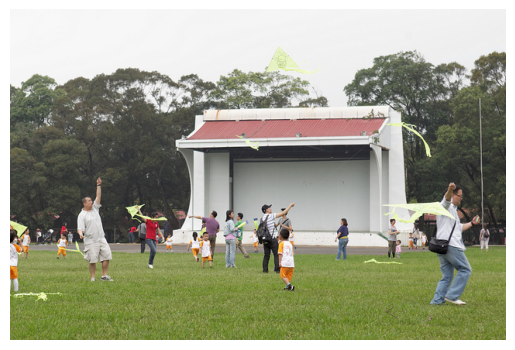

A large group of people in a field flying kites.
Large group of people in a field flying kites.
People are flying kites in a large field.
Adults and children are flying kites in a park.
A large group of people on a field with kites.


In [3]:
# pick a random image and display it
anns_id = random.choice(ids)
anns = coco.anns[anns_id]
img_id = anns['image_id']
img = coco.loadImgs(img_id)[0]
I = io.imread(img['coco_url'])
print('Image ID: ', img_id)
print('Image Height: ', img['height'])
print('Image Width: ', img['width'])
print('Image URL: ', img['coco_url'])
print('Image File Name: ', img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()
# load and display caption annotations
annIds = coco_caps.getAnnIds(imgIds=img_id)
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [4]:
class Vocab:
    def __init__(self, annotations_file, start_token, end_token, unknown_token, pad_token, threshold):
        self.start_token = start_token
        self.end_token = end_token
        self.unknown_token = unknown_token
        self.threshold = threshold
        self.pad_token = pad_token

        with open(annotations_file, 'r') as f:
            data = json.load(f)

        all_captions = [ann['caption'].lower() for ann in data['annotations']]
        words = [word for caption in all_captions for word in caption.split()]
        word_counter = Counter(words)

        self.vocab = [word for word, count in word_counter.items() if count >= self.threshold]
        self.vocab = [self.start_token, self.end_token, self.unknown_token, self.pad_token] + self.vocab
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for idx, word in enumerate(self.vocab)}

    def __len__(self):
        return len(self.vocab)

    def __call__(self, word):
        return self.word_to_idx.get(word, self.word_to_idx[self.unknown_token])

    def get_word_from_idx(self, idx):
        return self.idx_to_word[idx]

vocab = Vocab(annotations_file=captions_path, start_token='<sos>', end_token='<eos>', unknown_token='<unk>', pad_token='<pad>', threshold=5)
# print the size of the vocabulary
print('Vocabulary Size: ', len(vocab))
# print the first 10 words in the vocabulary
print('First 10 words in the vocabulary: ', vocab.vocab[:10])

Vocabulary Size:  11919
First 10 words in the vocabulary:  ['<sos>', '<eos>', '<unk>', '<pad>', 'a', 'very', 'clean', 'and', 'well', 'decorated']


In [5]:
class CocoDetection(VisionDataset):
    """`MS Coco Detection <https://cocodataset.org/#detection-2016>`_ Dataset.

    It requires the `COCO API to be installed <https://github.com/pdollar/coco/tree/master/PythonAPI>`_.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        transforms (callable, optional): A function/transform that takes input sample and its target as entry
            and returns a transformed version.
    """

    def __init__(
        self,
        root: str,
        annFile: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        transforms: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        from pycocotools.coco import COCO

        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(os.path.join(self.root, path)).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = [self._load_target(id)[i]['caption'] for i in range(len(self._load_target(id)))]

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self) -> int:
        return len(self.ids)

# create a CocoCaptioningDataset which takes the CocoDetection dataset as input and preprocesses the captions
class CocoCaptioningDataset(Dataset):
    def __init__(self, coco_detection_dataset, vocab, max_len=50):
        self.coco_detection_dataset = coco_detection_dataset
        self.vocab = vocab
        self.max_len = max_len

    def __getitem__(self, index):
        img, captions = self.coco_detection_dataset[index]
        # randomly select a caption
        captions = random.choice(captions)
        tokens = nltk.tokenize.word_tokenize(str(captions).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_token))
        caption.extend(self.vocab(word) for word in tokens)
        caption.append(self.vocab(self.vocab.end_token))
        # pad the caption if it is less than max_len
        caption.extend([self.vocab(self.vocab.pad_token)] * (self.max_len - len(caption)))
        targets = torch.Tensor(caption).long()
        return img, targets
    def __len__(self):
        return len(self.coco_detection_dataset)
    
    def preprocess(self, caption):
        # convert all words to lowercase
        caption = [[word.lower() for word in caption.split()]]

In [6]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
coco_detection_dataset = CocoDetection(root='train2014', annFile=captions_path, transform=transform)
coco_captioning_dataset = CocoCaptioningDataset(coco_detection_dataset, vocab)
coco_captioning_dataloader = DataLoader(coco_captioning_dataset, batch_size=32, shuffle=True)

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


In [7]:
# define EncoderCNN which uses a pretrained ResNet50 from timm
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        # freeze the weights of the pretrained model
        for param in self.resnet.parameters():
            param.requires_grad_(False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.embed_size = embed_size

    def forward(self, images):
        features = self.resnet(images)
        return features

# define DecoderRNN which takes the output of the EncoderCNN and predicts the next word in the caption
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # remove the last word from the captions
        captions = captions[:, :-1]
        embeddings = self.embedding(captions)
        # concatenate the features and embeddings
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        outputs, _ = self.lstm(inputs)
        outputs = self.fc(outputs)
        return outputs

    def sample(self, inputs, states=None, max_len=50):
        sampled_ids = []
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embedding(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

In [8]:
# define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the hyperparameters
embed_size = 256
hidden_size = 512
num_layers = 1
num_epochs = 5
learning_rate = 3e-4
batch_size = 32

# initialize the encoder and decoder
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)